
# Hyperparameter Optimization methods for CNNs using TensorFlow
---

## Setup

Import the libraries used throughout this notebook and configure reproducibility.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model
import tensorflow as tf
from keras.datasets import cifar10
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, Input, BatchNormalization, concatenate
from keras.utils import to_categorical, normalize
from keras import optimizers
import random

## Data loading and splitting

This notebook uses the **CIFAR-10 dataset**, which contains 60,000 color images
(32×32 pixels, 10 classes) commonly used for benchmarking image classification models.

Steps in this section:
1. Load CIFAR-10 from `keras.datasets`.
2. Split into **training** and **test** sets.
3. Inspect shapes to confirm that features and labels align.

**Checklist**
- Features `X` and labels `y` have matching lengths
- Train/validation/test proportions match the intended design
- No data leakage (test set isolated from any fitting)

In [10]:
(X_train, Y_train), (X_test, Y_test) = cifar10.load_data()

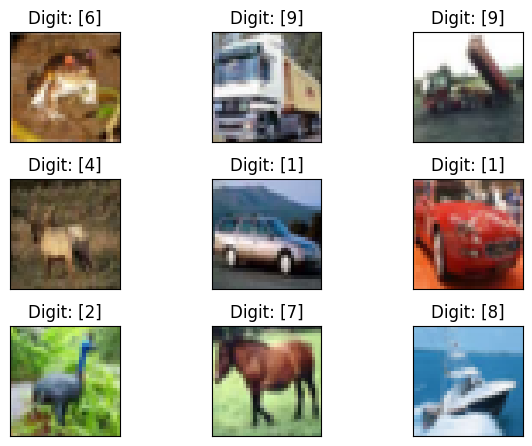

In [11]:
fig = plt.figure()
for i in range(9):
  plt.subplot(3,3,i+1)
  plt.tight_layout()
  plt.imshow(X_train[i], interpolation='none')
  plt.title("Digit: {}".format(Y_train[i]))
  plt.xticks([])
  plt.yticks([])

In [12]:
X_train.shape, Y_train.shape

((50000, 32, 32, 3), (50000, 1))

## Preprocessing
- **Feature scaling**: normalize/standardize inputs so gradients behave well and training converges faster.
- **Label encoding**: convert labels to categorical (for multi‑class softmax).

**Notes**
- Fit scalers on the *training* split only; apply to validation/test to avoid leakage.
- Keep track of the scaler object if you intend to serve the model later.

In [13]:
X_train_norm = tf.keras.utils.normalize(X_train)
X_test_norm = tf.keras.utils.normalize(X_test)

In [19]:
Y_train_cat = to_categorical(Y_train)
Y_test_cat = to_categorical(Y_test)

## Process

The experiment is done with two candidate neural network architectures selected from a prior notebook (Model A and Model B).  
The goal is to run a **randomized hyperparameter search** across both models, select the best configuration based on validation performance, explore different model behavior, and analyze results.

### Steps
1. Define the search space for each hyperparameter.
2. Sample random configurations and train/evaluate both models on the **same split**.
3. Track metrics and artifacts (best score, config, and notes).
4. Select the **best-performing model + hyperparameters** and explain the choice.
5. Train each model with the best hyperparameters and compare them.

### Hyperparameters to explore
- Optimization algorithm
- Learning rate
- Weight initialization
- Hidden-layer activation
- Dropout rate
- Hidden-layer width (neurons)
- Batch size

### Rationale
- **Optimizer & LR** drive convergence speed/stability.  
- **Initialization** affects early signal flow.  
- **Activation** shapes nonlinearity and gradient behavior.  
- **Dropout** regularizes to reduce overfitting.  
- **Width** trades capacity vs. overfitting/compute.  
- **Batch size** affects gradient noisee.

### Python lists for the search space:



In [14]:
# set a random seed:

np.random.seed(5)

optimizer    = ['SGD', 'RMSprop', 'Adam']
learn_rate   = [1e-4, 3e-4, 1e-3, 3e-3, 1e-2]
init_mode    = ['he_uniform', 'he_normal', 'glorot_uniform', 'glorot_normal']
activation   = ['relu', 'tanh', 'sigmoid']
dropout_rate = [0.0, 0.1, 0.2, 0.3]
filters      = [32, 64]
batch_size   = [128, 256]



### Custom randomized search (manual loop)

Below, hyperparameters are sampled randomly, train for up to 30 epochs with early stopping
(on **validation accuracy**), and store the full history for each trial.

**What gets recorded per trial**
- sampled hyperparameters,
- per-epoch `accuracy` and `val_accuracy`,
- `best_val_accuracy` and the epoch where it occurred,
- batch size used.

Afterward, a **sorted summary** and **plots** of validation accuracy over epochs is displayed.

In [15]:
def random_search(
    build_fn,  # your model builder (e.g. network or func_network)
    optimizer_choices,
    lr_choices,
    init_choices,
    activation_choices,
    dropout_choices,
    filter_choices,
    batch_choices,
    n_trials=10,
    epochs=30,
    val_split=0.2,
    patience=3,
):
    """
    Perform a custom random hyperparameter search.

    Returns:
        histories: list of dicts with training/validation accuracy per trial
        results: list of (trial, hyperparams, final_train_acc, final_val_acc)
    """
    histories = []
    results = []

    for i in range(1, n_trials + 1):
        # Sample random hyperparameters
        hp = {
            "optimizer": random.choice(optimizer_choices),
            "learn_rate": random.choice(lr_choices),
            "init_mode": random.choice(init_choices),
            "activation": random.choice(activation_choices),
            "dropout_rate": random.choice(dropout_choices),
            "filters": random.choice(filter_choices),
            "batch_size": random.choice(batch_choices),
        }

        print(f"\n{i} Training with: {hp}")

        # Build model
        model = build_fn(
            hp["optimizer"], hp["learn_rate"], hp["init_mode"],
            hp["activation"], hp["dropout_rate"], hp["filters"]
        )

        callback = tf.keras.callbacks.EarlyStopping(
            monitor="val_accuracy", patience=patience,
            mode="max", restore_best_weights=True, verbose=0
        )

        h = model.fit(
            X_train_norm, Y_train_cat,
            batch_size=hp["batch_size"],
            epochs=epochs,
            validation_split=val_split,
            callbacks=[callback],
            verbose=0,
        )

        run_results = {
            "train_acc": h.history["accuracy"],
            "val_acc": h.history["val_accuracy"],
        }

        final_train = run_results["train_acc"][-1]
        final_val = run_results["val_acc"][-1]

        print(f"Final training acc: {final_train:.4f}, Final val acc: {final_val:.4f}")

        histories.append(run_results)
        results.append((i, hp, final_train, final_val))

    return histories, results

def plot_histories(histories, title="Train vs Validation Accuracy"):
    """
    Plot training and validation accuracy curves for all trials.

    Args:
        histories (list of dict): Output from random_search, each dict has
                                  "train_acc" and "val_acc".
        title (str): Plot title
    """
    plt.figure(figsize=(12, 8))

    for i, h in enumerate(histories, 1):
        train_curve = np.asarray(h["train_acc"])
        val_curve = np.asarray(h["val_acc"])

        # Training curve (dashed)
        plt.plot(train_curve, linestyle="--", alpha=0.7, label=f"Train {i}")
        # Validation curve (solid)
        plt.plot(val_curve, alpha=0.9, label=f"Val {i}")

    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()

def plot_final_acc(results, title="Final Train vs Validation Accuracy"):
    """
    Plot final train and validation accuracy as bars for each trial.

    Args:
        results (list of tuples): (trial, hp, final_train, final_val)
    """
    trials = [r[0] for r in results]
    train_acc = [r[2] for r in results]
    val_acc = [r[3] for r in results]

    x = np.arange(len(trials))
    width = 0.35

    plt.figure(figsize=(12, 6))
    plt.bar(x - width/2, train_acc, width, label="Train Acc", alpha=0.7)
    plt.bar(x + width/2, val_acc, width, label="Val Acc", alpha=0.9)

    plt.xticks(x, [f"T{i}" for i in trials])
    plt.ylim(0, 1.0)
    plt.ylabel("Accuracy")
    plt.title(title)
    plt.legend()
    plt.grid(axis="y", linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.show()

### Model A: Simple CNN (for hyperparameter search)

Define a compact **Sequential** convolutional network to keep trials fast and comparable.  
The hyperparameters exposed for search are:

- `optimizer` and `learn_rate`
- `init_mode` (weight initializer)
- `activation` (hidden layers)
- `dropout_rate`
- `filters` (number of conv filters per block)

**Architecture (in order)**
1. `Conv2D → BatchNorm → Dropout` (3×3)
2. `Conv2D → BatchNorm → Dropout` (3×3) → `MaxPooling2D`
3. `Conv2D → BatchNorm → Dropout` (5×5) → `MaxPooling2D`
4. `Flatten`
5. `Dense(64, activation=<activation>)`
6. `Dense(10, activation='softmax')`

> Notes:
> - We apply the same `init_mode` consistently to conv and dense layers.
> - Use `categorical_crossentropy` (one-hot labels) or switch to `sparse_categorical_crossentropy` if labels are integers.
> - Keep input shape fixed at `(32, 32, 3)` for CIFAR-like images.

In [3]:
def network(optimizer, learn_rate, init_mode,
            activation, dropout_rate,
            filters):
  """
       The hyperparameters to search are listed as variables;
       Below are three Conv layers followed each by batch normalization
       dropout layers;

       Pooling layers were added two times;

       A dense layer with a preset number or filters, 64
       and activation function relu;

       the output dense layer with 10 filters and softmax activation
  """
  model = Sequential()

  model.add(Conv2D(filters, (3,3), activation = activation,
                   input_shape = (32,32,3), kernel_initializer=init_mode))
  model.add(BatchNormalization())
  model.add(Dropout(rate=dropout_rate))

  model.add(Conv2D(filters, (3,3), activation = activation))
  model.add(BatchNormalization())
  model.add(Dropout(rate=dropout_rate))
  model.add(MaxPool2D(2,2))

  model.add(Conv2D(filters, (5,5), activation = activation))
  model.add(BatchNormalization())
  model.add(Dropout(rate = dropout_rate))
  model.add(MaxPool2D(2,2))

  model.add(Flatten())

  model.add(Dense(64, activation = activation))
  model.add(Dense(10, activation = 'softmax'))


  model.compile(optimizer = optimizer,
                loss = 'categorical_crossentropy', metrics = ['accuracy'] )

  """
  The print hyperparameters found in the search
  """
  print('Optimizer: ' + optimizer+' ',
        'Learning rate: ' + str(learn_rate) + ' ',
       'Initiation mode: ' + init_mode +' ',
        'Activation: ' + activation +' ',
       'Dropout rate: ' + str(dropout_rate)+' ',
       'Number of filters: '+ str(filters))

  return model

### Random search

In [51]:
histories_seq, results_seq = random_search(
    build_fn=network,
    optimizer_choices=optimizer,
    lr_choices=learn_rate,
    init_choices=init_mode,
    activation_choices=activation,
    dropout_choices=dropout_rate,
    filter_choices=filters,
    batch_choices=batch_size,
    n_trials=10
)


1 Training with: {'optimizer': 'SGD', 'learn_rate': 0.0001, 'init_mode': 'glorot_normal', 'activation': 'relu', 'dropout_rate': 0.0, 'filters': 32, 'batch_size': 256}
Optimizer: SGD  Learning rate: 0.0001  Initiation mode: glorot_normal  Activation: relu  Dropout rate: 0.0  Number of filters: 32
Final training acc: 0.5425, Final val acc: 0.3171

2 Training with: {'optimizer': 'SGD', 'learn_rate': 0.003, 'init_mode': 'he_normal', 'activation': 'tanh', 'dropout_rate': 0.3, 'filters': 32, 'batch_size': 128}
Optimizer: SGD  Learning rate: 0.003  Initiation mode: he_normal  Activation: tanh  Dropout rate: 0.3  Number of filters: 32
Final training acc: 0.5261, Final val acc: 0.3421

3 Training with: {'optimizer': 'Adam', 'learn_rate': 0.003, 'init_mode': 'he_normal', 'activation': 'relu', 'dropout_rate': 0.1, 'filters': 32, 'batch_size': 128}
Optimizer: Adam  Learning rate: 0.003  Initiation mode: he_normal  Activation: relu  Dropout rate: 0.1  Number of filters: 32
Final training acc: 0.76

### Visualization of results
- Plotting the learning curves of all the random models:

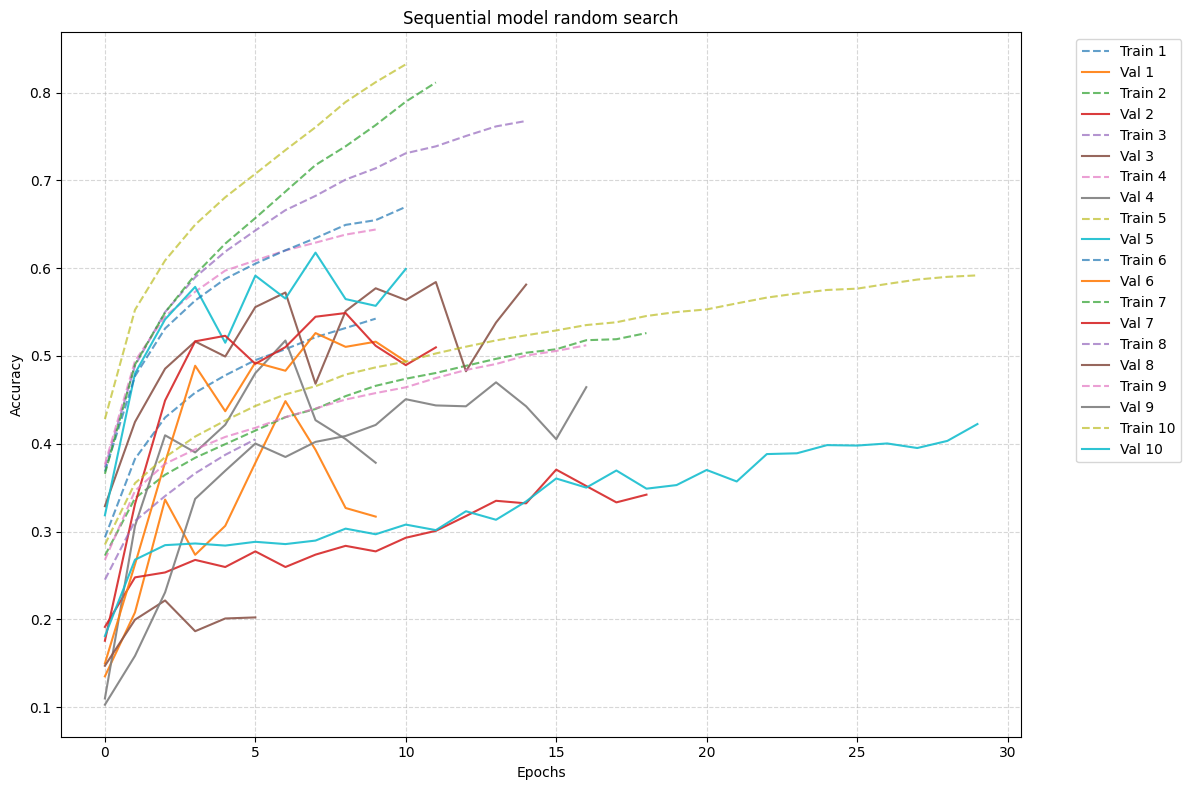

In [52]:
plot_histories(histories_seq, title="Sequential model random search")

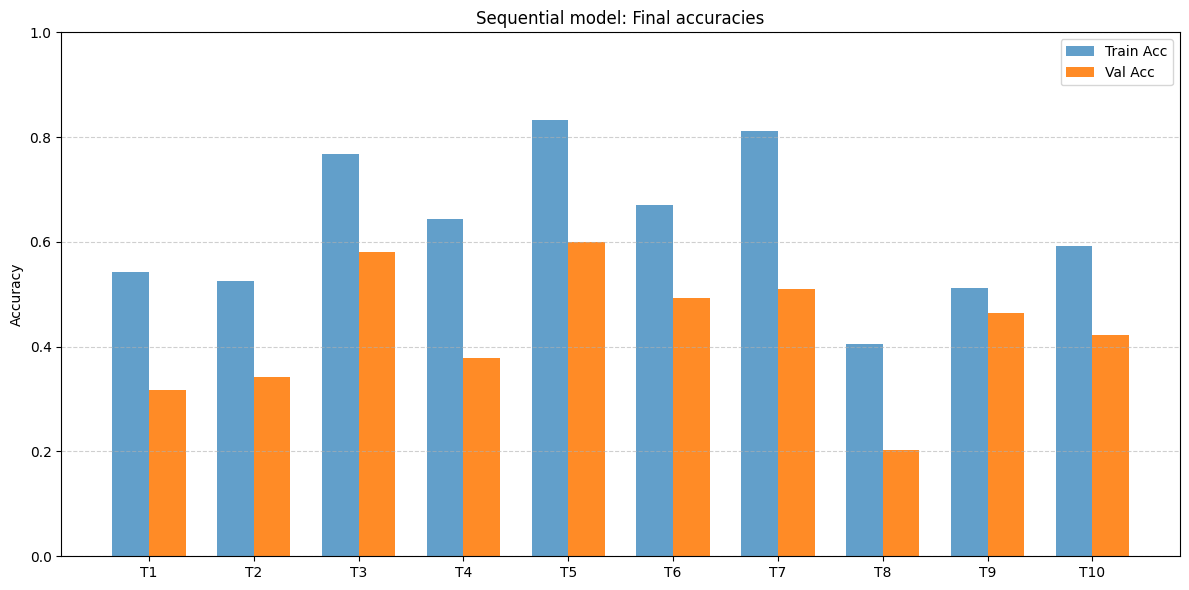

In [53]:
plot_final_acc(results_seq, title="Sequential model: Final accuracies")

## Results and Conclusion

### Random Search Outcomes
- Training accuracy often exceeded validation accuracy → signs of **overfitting**.  
- Best validation performance:  
  - **Trial 5** — *Adam, lr=1e-3, he_uniform, **sigmoid**, dropout=0.0, filters=64, batch=128*  
  **Val acc ≈ 0.599** | Train–Val gap ≈ 0.233  ← **Best val**
  - **Trial 3** — *Adam, lr=3e-3, he_normal, **ReLU**, dropout=0.1, filters=32, batch=128*  
  **Val acc ≈ 0.581** | Gap ≈ 0.186  ← strong runner-up with ReLU
  - **Trial 7** — *RMSprop, lr=1e-3, he_uniform, tanh, dropout=0.0, filters=64, batch=256*  
  **Val acc ≈ 0.510** | Gap ≈ 0.302

**Low gap but lower score:**  
- **Trial 9** — *SGD, lr=3e-3, glorot_uniform, sigmoid, dropout=0.0, filters=64, batch=256*  
  **Val acc ≈ 0.465** | **Gap ≈ 0.048** (best generalization gap, but lower absolute accuracy)

### Interpretation
- **Adam + moderate LR (1e-3 to 3e-3)** performed best.
- **Filters=64** helped the top run; **32** also worked with a good LR/activation (Trial 3).
- **ReLU** and **sigmoid** both appeared in top trials; ReLU is usually the safer default.
- **Minimal dropout (0.0–0.1)** worked best in this BN-equipped model.

### Pick for final training
- **Primary:** **Trial 5** (Adam, 1e-3, he_uniform, 64 filters, dropout=0.0) — highest validation accuracy.  


**Key takeaway:** Adam with a moderate learning rate and light/no dropout is the most reliable direction for this architecture; 64 filters edged out 32 in the best run, but both are viable with well-tuned LR/activation.

## Model B: Functional CNN

In the previous section, we used a simple Sequential model.  
Here, we redefine the network with Keras’ **Functional API**, which allows more flexible architectures.

### Architecture
- Two parallel convolutional branches:
  - Conv(3×3) → BatchNorm → Dropout → MaxPooling → Flatten
  - Conv(5×5) → BatchNorm → Dropout → MaxPooling → Flatten
- The two flattened outputs are concatenated
- Dense(64, relu)
- Dense(10, softmax)

This design lets the network learn from **different receptive field sizes** (3×3 and 5×5) and combine them before classification.

In [16]:
def func_network(optimizer, learn_rate, init_mode,
            activation, dropout_rate,
            filters):

  inputs = Input(shape=(32,32,3))

  """
        Two parallel conv branches (3×3 and 5×5), each with
        BatchNorm, Dropout, and MaxPooling. Flattened outputs
        are concatenated, followed by Dense(64, relu) and
        a Dense(10, softmax) classifier.
  """

  x = Conv2D(filters,(3,3), activation=activation,
             kernel_initializer = init_mode)(inputs)
  x1 = BatchNormalization()(x)
  x2 = Dropout(rate=dropout_rate)(x1)
  x3 = MaxPool2D(2,2)(x2)
  x4 = Flatten()(x3)


  y = Conv2D(filters,(5,5), activation=activation,
            kernel_initializer = init_mode)(inputs)
  y1 = BatchNormalization()(y)
  y2 = Dropout(rate=dropout_rate)(y)
  y3 = MaxPool2D(2,2)(y2)
  y4 = Flatten()(y3)


  a = concatenate([x4, y4])


  dense = Dense(64, activation = 'relu')(a)

  outputs = Dense(10, activation = 'softmax')(dense)

  func_model = Model(inputs, outputs)

  func_model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])
  """
  print hyperparameters found in the search
  """
  print('Optimizer: ' + optimizer+' ',
        'Learning rate: ' + str(learn_rate) + ' ',
       'Initiation mode: ' + init_mode +' ',
        'Activation: ' + activation +' ',
       'Dropout rate: ' + str(dropout_rate)+' ',
       'Number of filters: '+ str(filters))

  return func_model

### Randomized hyperparameter search (manual loop)

The same manual random-search procedure as in Model A is repeated here, but using the functional architecture.
Each trial samples hyperparameters, trains with early stopping, and records the learning curve.

In [29]:
histories_func, results_func = random_search(
    build_fn=func_network,
    optimizer_choices=optimizer,
    lr_choices=learn_rate,
    init_choices=init_mode,
    activation_choices=activation,
    dropout_choices=dropout_rate,
    filter_choices=filters,
    batch_choices=batch_size,
    n_trials=10
)


1 Training with: {'optimizer': 'SGD', 'learn_rate': 0.001, 'init_mode': 'he_normal', 'activation': 'sigmoid', 'dropout_rate': 0.2, 'filters': 32, 'batch_size': 128}
Optimizer: SGD  Learning rate: 0.001  Initiation mode: he_normal  Activation: sigmoid  Dropout rate: 0.2  Number of filters: 32
Final training acc: 0.6138, Final val acc: 0.4751

2 Training with: {'optimizer': 'SGD', 'learn_rate': 0.01, 'init_mode': 'glorot_uniform', 'activation': 'relu', 'dropout_rate': 0.1, 'filters': 32, 'batch_size': 256}
Optimizer: SGD  Learning rate: 0.01  Initiation mode: glorot_uniform  Activation: relu  Dropout rate: 0.1  Number of filters: 32
Final training acc: 0.5138, Final val acc: 0.3993

3 Training with: {'optimizer': 'SGD', 'learn_rate': 0.0003, 'init_mode': 'glorot_normal', 'activation': 'relu', 'dropout_rate': 0.1, 'filters': 32, 'batch_size': 256}
Optimizer: SGD  Learning rate: 0.0003  Initiation mode: glorot_normal  Activation: relu  Dropout rate: 0.1  Number of filters: 32
Final traini

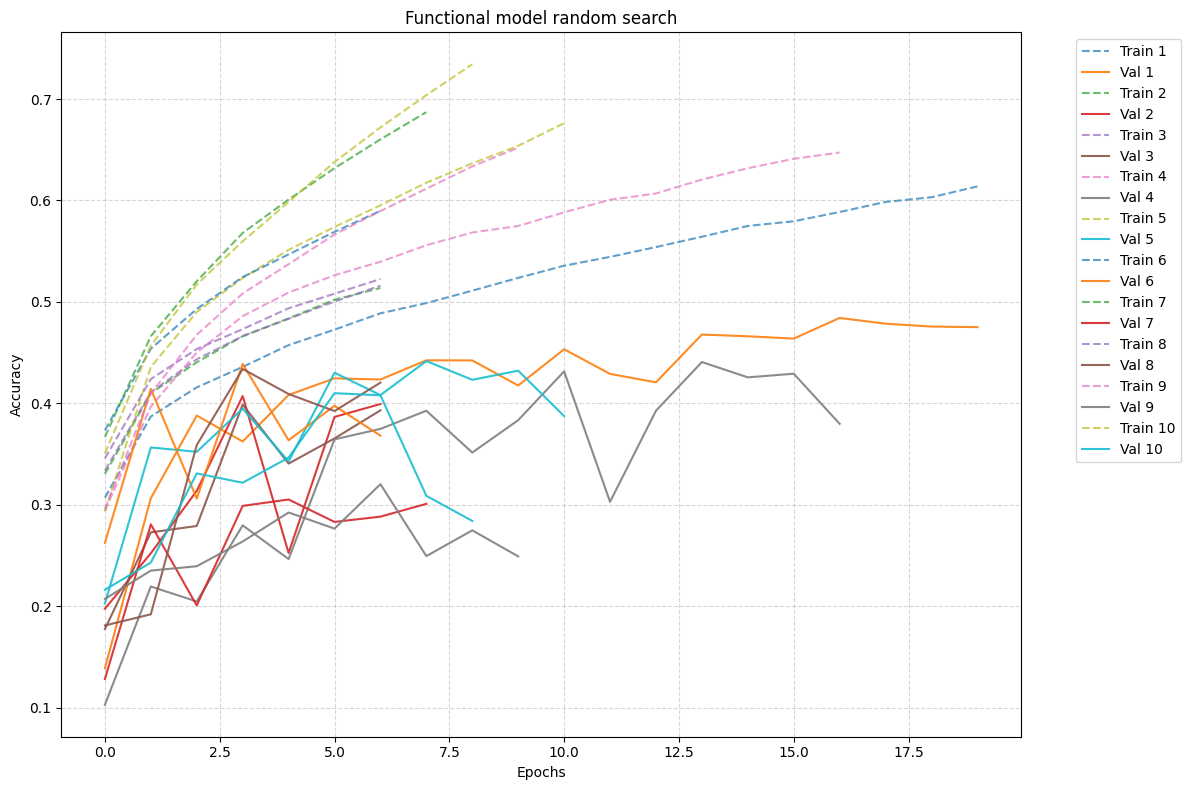

In [30]:
plot_histories(histories_func, title="Functional model random search")

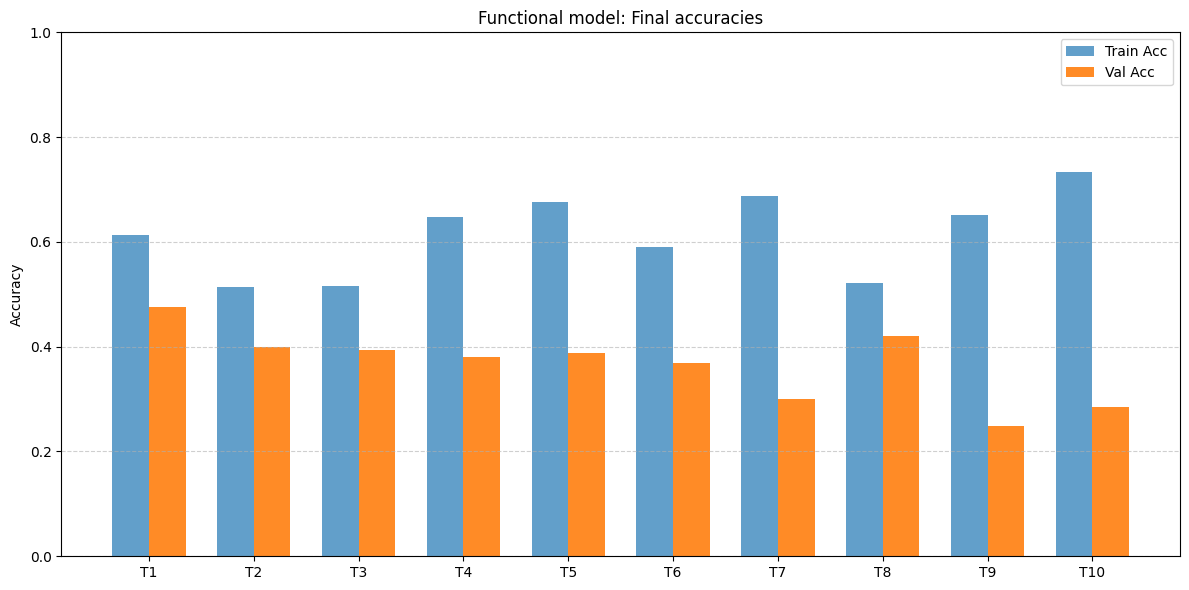

In [31]:
plot_final_acc(results_func, title="Functional model: Final accuracies")

### Overall pattern
- The functional model generally **trained faster** than the sequential version.  
- Training accuracy reached ~ 0.60–0.73 in most runs, but validation accuracy lagged behind (~0.25–0.47).  
- This gap indicates **overfitting**, though some configurations generalized better than others.  

### Best trials by validation accuracy
- **Trial 1** — *SGD, lr=1e-3, he_normal, sigmoid, dropout=0.2, filters=32, batch=128* → **Val acc ≈ 0.48**  
- **Trial 8** — *SGD, lr=1e-2, glorot_uniform, tanh, dropout=0.0, filters=32, batch=256* → **Val acc ≈ 0.42**  
- **Trial 2** — *SGD, lr=1e-2, glorot_uniform, ReLU, dropout=0.1, filters=32, batch=256* → **Val acc ≈ 0.40**  

### Notable underperformers
- **Trials 7, 9, 10** with RMSprop and larger filter sizes (64) dropped to **val acc ≈ 0.25–0.30**, showing poor generalization despite decent training accuracy.  
- Models with **higher dropout (0.2) and RMSprop** often stalled at low validation scores.  

### What helped
- **SGD** with moderate learning rates (1e-3 to 1e-2) was the most consistent optimizer in this setup.  
- **Low or no dropout** (0.0–0.1) gave the best validation performance.  
- **32 filters** outperformed 64, similar to the sequential case.  
- Interestingly, **sigmoid and tanh** activations sometimes edged out ReLU, though none surpassed ~0.48 val acc.  

### Conclusion
The functional model performed slightly better in terms of training speed and produced competitive validation accuracy (best ≈ 0.48). The most promising run was **Trial 1 (SGD, lr=1e-3, sigmoid, dropout=0.2, filters=32, batch=128)**.  
Overall, SGD with moderate learning rates and compact architectures (32 filters, light dropout) appear to be the best direction for functional models.

# Training best variants



In [17]:
# === Reusable utilities ===

def summarize_and_plot_model(model, filename="model.png", dpi=110):
    """Print a text summary and save/display a model diagram."""
    model.summary()
    plot_model(model, to_file=filename, show_shapes=True, show_layer_names=True, dpi=dpi)
    display(Image(filename=filename, retina=True))

def default_callbacks(patience=5, monitor="val_accuracy", ckpt_path="best_model.weights.h5"):
    """Standard callbacks: EarlyStopping, ReduceLROnPlateau, ModelCheckpoint (weights only)."""
    cbs = [
        tf.keras.callbacks.EarlyStopping(
            monitor=monitor, patience=patience, mode="max", restore_best_weights=True
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor=monitor, factor=0.5, patience=max(2, patience//2), min_lr=1e-5, mode="max", verbose=1
        ),
        tf.keras.callbacks.ModelCheckpoint(
            filepath=ckpt_path, monitor=monitor, mode="max",
            save_best_only=True, save_weights_only=True, verbose=0
        ),
    ]
    return cbs

def train_model(model, X_train, y_train, *, batch_size=128, epochs=200,
                val_split=0.2, callbacks=None, verbose=1):
    """Fit a model and return the History object."""
    callbacks = callbacks or default_callbacks()
    history = model.fit(
        X_train, y_train,
        batch_size=batch_size,
        epochs=epochs,
        validation_split=val_split,
        callbacks=callbacks,
        verbose=verbose
    )
    return history

def plot_history(history, title_prefix="Model"):
    """Plot train/val accuracy and loss (if available)."""
    H = history.history
    # Accuracy
    if "accuracy" in H and "val_accuracy" in H:
        plt.figure(figsize=(6,4))
        plt.plot(H["accuracy"], label="Train acc", linestyle="--")
        plt.plot(H["val_accuracy"], label="Val acc")
        plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.title(f"{title_prefix} accuracy")
        plt.legend(); plt.grid(alpha=0.4); plt.tight_layout(); plt.show()
    # Loss
    if "loss" in H and "val_loss" in H:
        plt.figure(figsize=(6,4))
        plt.plot(H["loss"], label="Train loss", linestyle="--")
        plt.plot(H["val_loss"], label="Val loss")
        plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title(f"{title_prefix} loss")
        plt.legend(); plt.grid(alpha=0.4); plt.tight_layout(); plt.show()

def evaluate_model(model, X_test, y_test, *, verbose=0):
    """Evaluate on test data and print nicely."""
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=verbose)
    print(f"Test loss: {test_loss:.4f} | Test accuracy: {test_acc:.4f}")
    return test_loss, test_acc


## Model A

Optimizer: adam  Learning rate: 0.001  Initiation mode: he_uniform  Activation: relu  Dropout rate: 0.0  Number of filters: 64


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 30, 30, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 30, 30, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 28, 28, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 28, 28, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 10, 10, 64)     │       102,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 10, 10, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │       102,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 245,066 (957.29 KB)

 Trainable params: 244,682 (955.79 KB)

 Non-trainable params: 384 (1.50 KB)

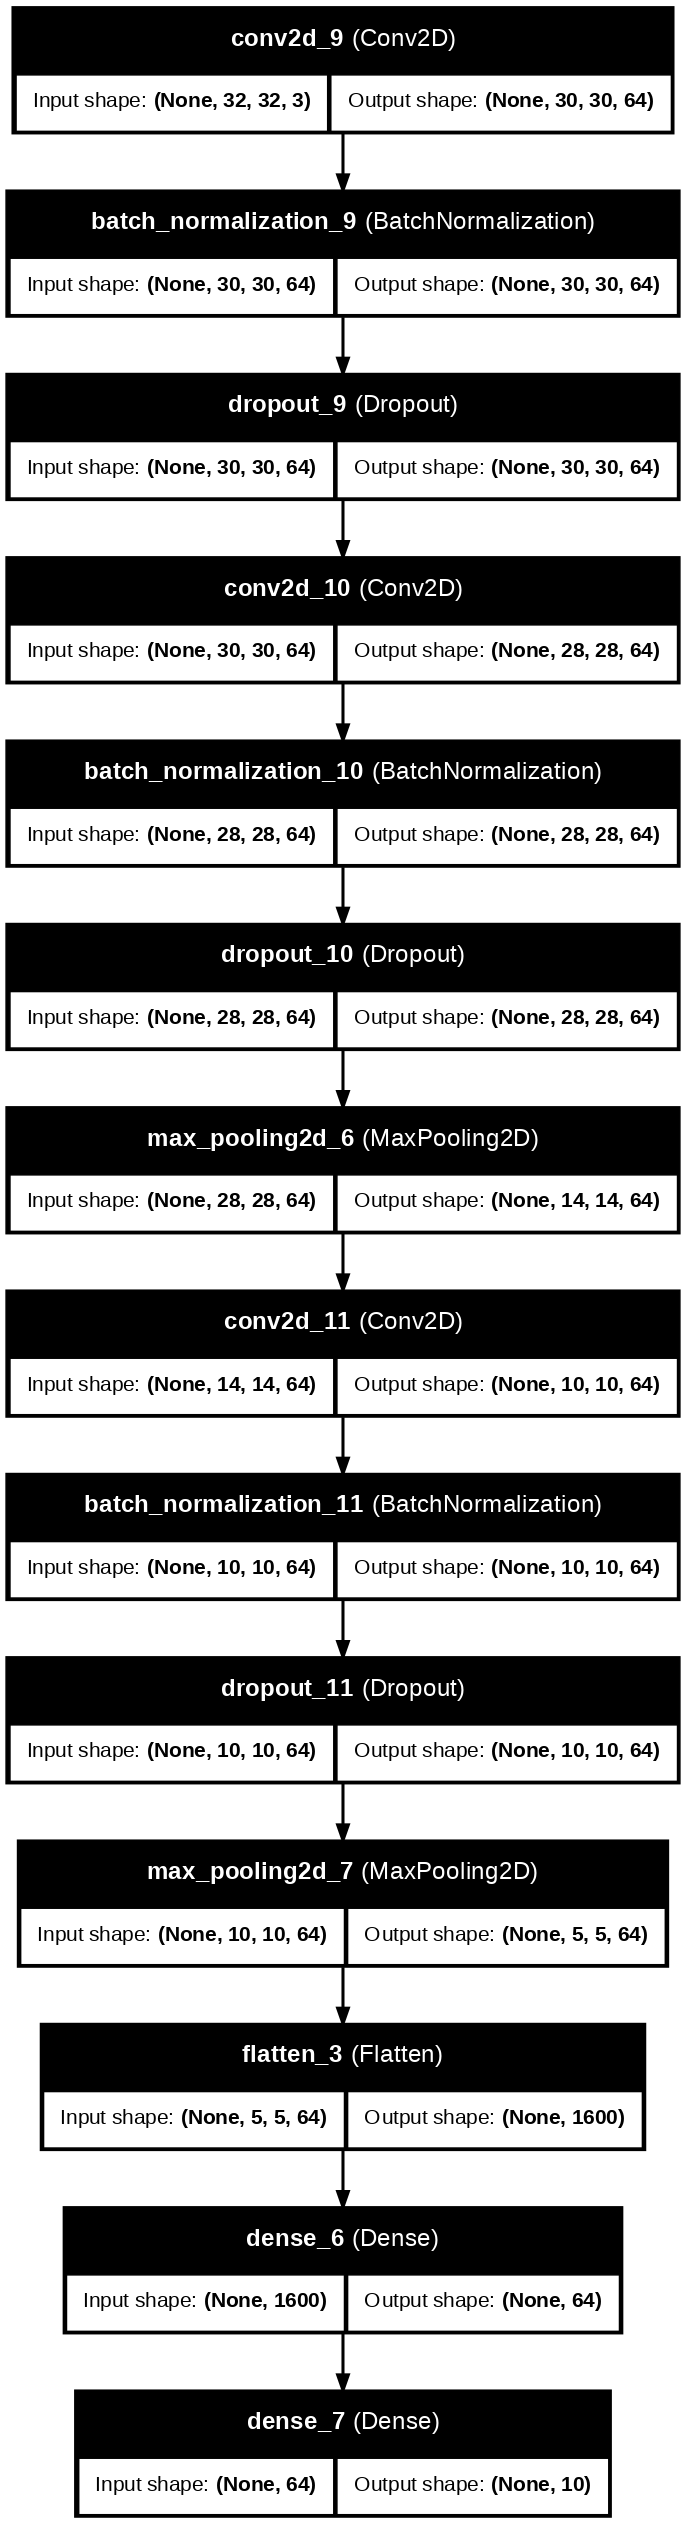

In [8]:
# --- Model A (Sequential) final run with bestA ---

from IPython.display import Image

bestA = {
    "optimizer": "adam",
    "learn_rate": 1e-3,
    "init_mode": "he_uniform",
    "activation": "relu",
    "dropout_rate": 0.0,
    "filters": 64,
    "batch": 128,
}

# 1) Build the model with your builder
modelA = network(
    bestA["optimizer"],
    bestA["learn_rate"],
    bestA["init_mode"],
    bestA["activation"],
    bestA["dropout_rate"],
    bestA["filters"]
)

# Ensure the learning rate is actually applied
opt = tf.keras.optimizers.get(
    {"class_name": bestA["optimizer"], "config": {"learning_rate": bestA["learn_rate"]}}
)
# keep current loss/metrics, just swap optimizer to ensure LR is set
modelA.compile(optimizer=opt, loss=modelA.loss, metrics=['accuracy'])

# Callbacks
cbs = [
    tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=5, mode="max", restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor="val_accuracy", factor=0.5, patience=2, min_lr=1e-5, mode="max", verbose=1),
    tf.keras.callbacks.ModelCheckpoint(filepath="modelA_best.weights.h5", monitor="val_accuracy",
                                       mode="max", save_best_only=True, save_weights_only=True)
]

# Summary + diagram
modelA.summary()
plot_model(modelA, to_file="modelA.png", show_shapes=True, show_layer_names=True, dpi=110)
display(Image(filename="modelA.png", retina=True))

Epoch 1/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 20s 41ms/step - accuracy: 0.3513 - loss: 1.8616 - val_accuracy: 0.3636 - val_loss: 1.8109 - learning_rate: 0.0010
Epoch 2/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.5381 - loss: 1.3029 - val_accuracy: 0.4208 - val_loss: 1.6965 - learning_rate: 0.0010
Epoch 3/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.6166 - loss: 1.0886 - val_accuracy: 0.4806 - val_loss: 1.4914 - learning_rate: 0.0010
Epoch 4/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.6704 - loss: 0.9309 - val_accuracy: 0.5144 - val_loss: 1.5748 - learning_rate: 0.0010
Epoch 5/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.7281 - loss: 0.7811 - val_accuracy: 0.5734 - val_loss: 1.3034 - learning_rate: 0.0010
Epoch 6/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.7629 - loss: 0.6781 - val_accuracy: 0.4663 - val_loss: 2.2670 - learning_rate: 0.0010
Epoch 7/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8027 - 

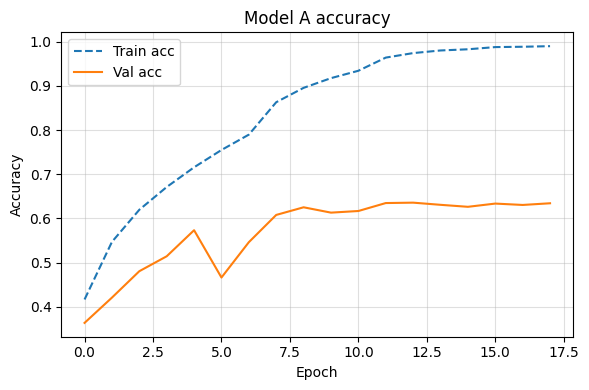

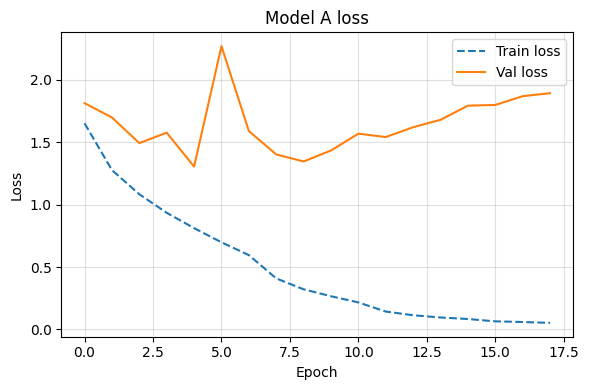

[Model A] Best val acc: 0.6358 | Test acc: 0.6357


In [20]:
# Train
histA = modelA.fit(
    X_train_norm, Y_train_cat,
    epochs=200,
    batch_size=bestA["batch"],
    validation_split=0.2,
    callbacks=cbs,
    verbose=1
)

# Plot accuracy (and loss if available)
H = histA.history
plt.figure(figsize=(6,4))
plt.plot(H["accuracy"], label="Train acc", linestyle="--")
plt.plot(H["val_accuracy"], label="Val acc")
plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.title("Model A accuracy")
plt.legend(); plt.grid(alpha=0.4); plt.tight_layout(); plt.show()

if "loss" in H and "val_loss" in H:
    plt.figure(figsize=(6,4))
    plt.plot(H["loss"], label="Train loss", linestyle="--")
    plt.plot(H["val_loss"], label="Val loss")
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Model A loss")
    plt.legend(); plt.grid(alpha=0.4); plt.tight_layout(); plt.show()

# 7) Evaluate on test set
test_loss_A, test_acc_A = modelA.evaluate(X_test_norm, Y_test_cat, verbose=0)
print(f"[Model A] Best val acc: {max(H['val_accuracy']):.4f} | Test acc: {test_acc_A:.4f}")


## Model B

Optimizer: SGD  Learning rate: 0.001  Initiation mode: he_normal  Activation: sigmoid  Dropout rate: 0.2  Number of filters: 32


Model: "functional_71"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_17 (Conv2D)  │ (None, 30, 30,    │        896 │ input_layer_6[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 30, 30,    │        128 │ conv2d_17[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_18 (Conv2D)  │ (None, 28, 28,    │      2,432 │ input_layer_6[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_17          │ (None, 30, 30,    │          0 │ batch_normalizat… │
│ (Dropout)           │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_18          │ (None, 28, 28,    │          0 │ conv2d_18[0][0]   │
│ (Dropout)           │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_12    │ (None, 15, 15,    │          0 │ dropout_17[0][0]  │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_13    │ (None, 14, 14,    │          0 │ dropout_18[0][0]  │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_7 (Flatten) │ (None, 7200)      │          0 │ max_pooling2d_12… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_8 (Flatten) │ (None, 6272)      │          0 │ max_pooling2d_13… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 13472)     │          0 │ flatten_7[0][0],  │
│ (Concatenate)       │                   │            │ flatten_8[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 64)        │    862,272 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 10)        │        650 │ dense_12[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 866,378 (3.30 MB)

 Trainable params: 866,314 (3.30 MB)

 Non-trainable params: 64 (256.00 B)

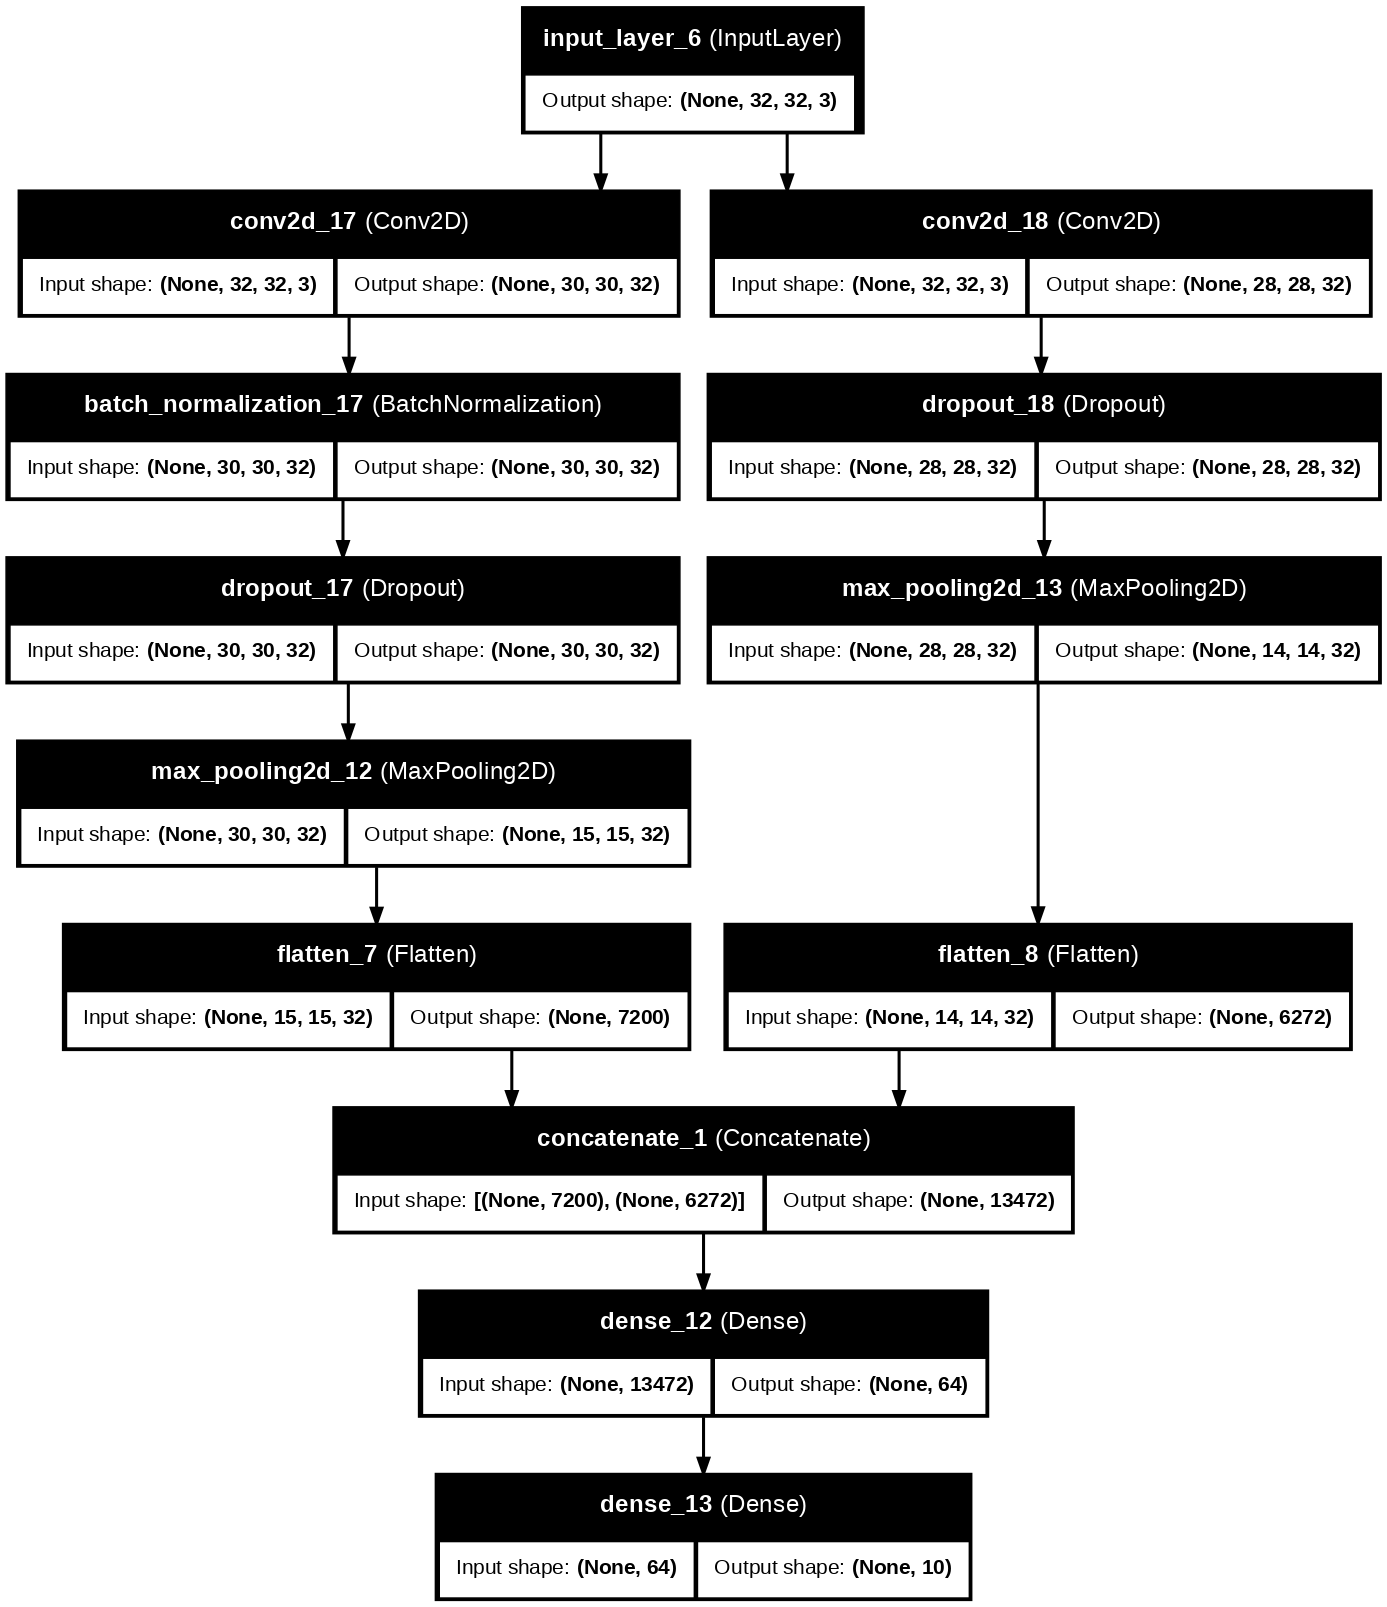

In [23]:
# --- Model B (Functional) ---
bestB = {
    "optimizer": "SGD",
    "learn_rate": 1e-3,
    "init_mode": "he_normal",
    "activation": "sigmoid",
    "dropout_rate": 0.2,
    "filters": 32,
    "batch": 128,
}

# Build & train (uses your existing func_network builder)
modelB = func_network(
    bestB["optimizer"],
    bestB["learn_rate"],
    bestB["init_mode"],
    bestB["activation"],
    bestB["dropout_rate"],
    bestB["filters"],
)

# Ensure the learning rate is actually applied
opt = tf.keras.optimizers.get(
    {"class_name": bestB["optimizer"], "config": {"learning_rate": bestB["learn_rate"]}}
)
# keep current loss/metrics, just swap optimizer to ensure LR is set
modelB.compile(optimizer=opt, loss=modelB.loss, metrics=['accuracy'])

# Callbacks
cbs = [
    tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=5, mode="max", restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor="val_accuracy", factor=0.5, patience=2, min_lr=1e-5, mode="max", verbose=1),
    tf.keras.callbacks.ModelCheckpoint(filepath="modelA_best.weights.h5", monitor="val_accuracy",
                                       mode="max", save_best_only=True, save_weights_only=True)
]

# Summary + diagram
modelB.summary()
plot_model(modelB, to_file="modelB.png", show_shapes=True, show_layer_names=True, dpi=110)
display(Image(filename="modelB.png", retina=True))

Epoch 1/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - accuracy: 0.2120 - loss: 2.1727 - val_accuracy: 0.2423 - val_loss: 2.1277 - learning_rate: 0.0010
Epoch 2/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.3171 - loss: 1.9150 - val_accuracy: 0.3249 - val_loss: 1.9227 - learning_rate: 0.0010
Epoch 3/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.3453 - loss: 1.8457 - val_accuracy: 0.3362 - val_loss: 1.8761 - learning_rate: 0.0010
Epoch 4/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.3672 - loss: 1.8003 - val_accuracy: 0.3478 - val_loss: 1.8459 - learning_rate: 0.0010
Epoch 5/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.3830 - loss: 1.7590 - val_accuracy: 0.3592 - val_loss: 1.8256 - learning_rate: 0.0010
Epoch 6/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.3919 - loss: 1.7338 - val_accuracy: 0.3681 - val_loss: 1.8054 - learning_rate: 0.0010
Epoch 7/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.4014 - loss: 

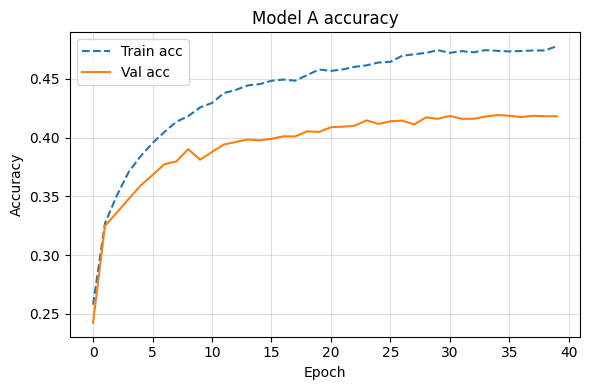

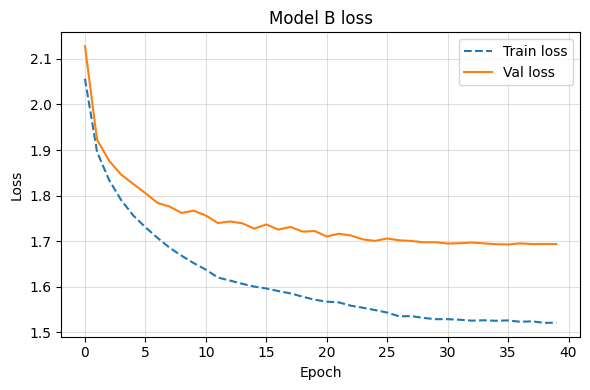

[Model B] Best val acc: 0.4192 | Test acc: 0.4279


In [24]:
# Train
histB = modelB.fit(
    X_train_norm, Y_train_cat,
    epochs=200,
    batch_size=bestA["batch"],
    validation_split=0.2,
    callbacks=cbs,
    verbose=1
)

# Plot accuracy (and loss if available)
J = histB.history
plt.figure(figsize=(6,4))
plt.plot(J["accuracy"], label="Train acc", linestyle="--")
plt.plot(J["val_accuracy"], label="Val acc")
plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.title("Model A accuracy")
plt.legend(); plt.grid(alpha=0.4); plt.tight_layout(); plt.show()

if "loss" in J and "val_loss" in J:
    plt.figure(figsize=(6,4))
    plt.plot(J["loss"], label="Train loss", linestyle="--")
    plt.plot(J["val_loss"], label="Val loss")
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Model B loss")
    plt.legend(); plt.grid(alpha=0.4); plt.tight_layout(); plt.show()

# Evaluate on test set
test_loss_B, test_acc_B = modelB.evaluate(X_test_norm, Y_test_cat, verbose=0)
print(f"[Model B] Best val acc: {max(J['val_accuracy']):.4f} | Test acc: {test_acc_B:.4f}")

# Conclusions

**Goal:**

Compare two CNN architectures on CIFAR-10—**Model A (Sequential)** and **Model B (Functional)**—by:
1. random hyperparameter search, then
2. retraining each with a robust training recipe (EarlyStopping, ReduceLROnPlateau, checkpointing).

**What worked:**
- **Learning rate:**
  - Moderate LRs (≈ 1e-3 to 1e-2) consistently beat very low LRs.
- **Optimizers:**
  - Model A, Adam/RMSprop were strongest;
  - Model B, SGD at moderate LR was competitive.

- **Regularization:**
  - With BatchNorm, light or no dropout (0.0–0.2) performed best.

- **Capacity:**
  - 32–64 filters were sufficient; gains came more from LR/optimizer than width.

**Best observed performance (validation).**

- **Model A (Sequential):** ~**0.63–0.60** val acc in top trials (e.g., Adam @ 1e-3, He init, ReLU, dropout ≤0.1, 32–64 filters).  
- **Model B (Functional):** ~**0.48–0.50** val acc in best runs (e.g., SGD @ 1e-3–1e-2, light dropout, 32 filters).  
Both models showed a train > val gap, but the callback stack helped cap overfitting.

**Why Model A can be slower despite fewer parameters:**

- Compute is dominated by convolution FLOPs (Floating Point Operations), not parameter count.  
- Model A does more convs at higher spatial resolution (before pooling, including a 5×5), so each step processes more pixels: roughly proportional to  
  *H × W × kernel² × in_channels × out_channels*.  
- Model B pools earlier per branch, so more work happens on downsampled maps → fewer FLOPs per step and faster training, even if it has more parameters.

**Training recipe wins** because EarlyStopping (patience≈5), ReduceLROnPlateau, and checkpointing improved stability and final val accuracy without changing architecture.

**Next steps (no architecture changes).**
1. Lock in best configs and train a bit longer with the same callbacks.  
2. Add Mixed precision on GPU.

**Key takeaway:**

 With matched loss and a stronger training recipe, **Model A (Sequential)** currently delivers the best validation accuracy, while **Model B (Functional)** trains faster per epoch due to lower FLOPs. Future gains will likely come from optimization and data-pipeline tweaks rather than widening the network.